## **Twitter Word Embeddings**

Import packages

In [2]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
from numpy import array
from numpy import asarray
from numpy import zeros
import tensorflow as tf

Using TensorFlow backend.


Download stopwords from NLTK

In [3]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Set parameters

In [0]:
NB_WORDS = 2500  # Number of words in dictionary
NB_START_EPOCHS = 5  # Number of epochs
BATCH_SIZE = 64  # Size of the batches used in the gradient descent
MAX_LEN = 140  # Maximum number of words in a tweet
NUM_EMBED = 100 # Number of embeddings
NUM_TWEETS = 100

#171296

Text cleaning functions

In [0]:
# CITATION: https://github.com/bertcarremans/TwitterUSAirlineSentiment/blob/master/source/Using%20Word%20Embeddings%20for%20Sentiment%20Analysis.ipynb

# Function to remove stopwords
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a series.
    
    Input:
        input_text : text to clean

    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = str(input_text).split() 
    clean_words = [word for word in words if (word not in stopwords_list or word\
                                              in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 


# Function to remove mentions (@)
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a pandas series.
    
    Input:
        input_text : text to clean
    
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)  

Load tweets, shuffle, and clean

In [6]:
# Load tweets and shuffle by index, remove stopwords
df = pd.read_csv('all_tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['county', 'date', 'text']]
df.head()

,county,date,text
90463,Lake,2020-05-31T17:36:17Z,"We got a global pandemic, riots in every major..."
116090,McDonough,2020-04-22T13:01:27Z,Jeter Adds Experience in First Recruiting Clas...
158324,Wayne,2020-05-20T07:49:05Z,Can you read?
32150,Cook,2020-06-06T18:45:59Z,Now tell us which group rarely suffers any con...
68020,Jasper,2020-03-04T01:18:34Z,This is what we like to hear


In [0]:
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [8]:
df.head()

,county,date,text
90463,Lake,2020-05-31T17:36:17Z,"We got global pandemic, riots every major city..."
116090,McDonough,2020-04-22T13:01:27Z,Jeter Adds Experience First Recruiting Class. ...
158324,Wayne,2020-05-20T07:49:05Z,Can read?
32150,Cook,2020-06-06T18:45:59Z,Now tell us group rarely suffers consequences so.
68020,Jasper,2020-03-04T01:18:34Z,This like hear


Tokenize, Set to Lowercase, Split on Spaces

In [0]:
# Convert words to a sequence of integers (tokenizer)
# Additionally, clean tweets, set to lowercase, split on spaces
tk = Tokenizer(num_words=NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', lower=True, split=" ")
tk.fit_on_texts(df.text)
X_seq = tk.texts_to_sequences(df.text)

Pad Sentences

In [0]:
# Make sentences equal lengths using padding
X_seq_trunc = pad_sequences(X_seq, maxlen=MAX_LEN)

Import Glove File

In [0]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

Create embedding dictionary

In [0]:
# Word = key, 100 dim embedding vector = value
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

Create an embedding matrix (vocab size x 100)

In [0]:
# Find vectors for each of the words
embedding_matrix = zeros((NB_WORDS, NUM_EMBED))
for word, index in tk.word_index.items():
    if index < NB_WORDS:
      embedding_vector = embeddings_dictionary.get(word)
      if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
      break

Create an empty placeholder matrix

In [0]:
placeholder = zeros((NB_WORDS, NUM_TWEETS, NUM_EMBED), dtype=object)

Create final matrix: words x tweets x embeddings

In [0]:
reverse_lookup = {value: key for key, value in tk.word_index.items()}
for i, tweet in enumerate(X_seq_trunc[:NUM_TWEETS]):
  for j, word in enumerate(tweet):
    if word == 0:
      placeholder[j, i] = zeros(100)
    else:
      text = reverse_lookup[word]
      if text not in embeddings_dictionary:
        placeholder[j, i] = zeros(100)
      else:
        emb = embeddings_dictionary[text]
        placeholder[j, i] = emb

In [0]:
# Find the max value for each embedding across each tweet
squash = placeholder.max(0)
df_squash = pd.DataFrame(squash)
stacked = pd.concat([df, df_squash], axis=1)
stacked.head()

Find average embedding by county-date

In [0]:
df_with_embeddings = stacked
df_with_embeddings['date'] = pd.to_datetime(df_with_embeddings['date'])
df_with_embeddings['just_date'] = df_with_embeddings['date'].dt.date 
df_with_embeddings['just_date'] = pd.to_datetime(df_with_embeddings['just_date'])

cols = [] 
for i in range(100): 
    cols.append(i)
    df_with_embeddings[i] = pd.to_numeric(df_with_embeddings[i])
df_with_embeddings = df_with_embeddings.groupby(['county', 'just_date'])[cols].mean()

In [0]:
df_with_embeddings = stacked
df_with_embeddings['date'] = pd.to_datetime(df_with_embeddings['date'])
df_with_embeddings['just_date'] = df_with_embeddings['date'].dt.date 
df_with_embeddings['just_date'] = pd.to_datetime(df_with_embeddings['just_date'])

In [0]:
df_with_embeddings.fillna(0, inplace=True)

In [0]:
df_with_embeddings['date'] = pd.to_datetime(df_with_embeddings['date'])
df_with_embeddings['just_date'] = df_with_embeddings['date'].dt.date 
cols = [] 
for i in range(100): 
    cols.append(i)
words = df_with_embeddings.groupby(['county', 'just_date'])[cols].mean()

Merge 'words' with other indicators 'merged'

In [0]:
# Bring in other indicators
merged = pd.read_csv('clean_merged_with_outcome.csv')
merged = merged.iloc[:,1:]
merged = merged.rename(columns={"county.x": "county", "date": "just_date"})
merged = merged.drop(['grade_distance'], axis=1)

In [0]:
words.reset_index(inplace=True)

In [0]:
words['county'] = words['county'].astype(str)
words['just_date'] = pd.to_datetime(words['just_date'], utc=True)

In [0]:
merged['county'] = merged['county'].astype(str)
merged['just_date'] = pd.to_datetime(merged['just_date'], utc=True)

In [0]:
words['county'] = words['county'].astype(str) + ' County'

In [0]:
final_df = pd.merge(words, merged, how = 'inner', left_on=['county','just_date'], right_on=['county','just_date'])

In [0]:
final_df.fillna(0, inplace=True)

Train Test Split




In [0]:
train, test = train_test_split(final_df, test_size=0.1)

In [0]:
# Train test split continued
y_train = train[['outcome']]
X_train = train.iloc[:,2:123]
y_test = test[['outcome']]
X_test = test.iloc[:,2:123]

In [0]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
dataset_train = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))

In [0]:
# for feat, targ in dataset_train.take(3):
#   print ('Features: {}, Target: {}'.format(feat, targ))

In [0]:
# Citation: https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

Run Final Neural Net!

In [0]:
def get_compiled_model(embedding_dim, hidden_dim, out_dim):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(out_dim)
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  # tf.keras.metrics.Precision
  return model

In [257]:
# Compile and fit model
model = get_compiled_model(121, 50, 1)
model.fit(dataset_train, epochs=NB_START_EPOCHS)

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

4256/4256 [==============================] - 9s 2ms/step - loss: 2.2543 - accuracy: 0.8539
Epoch 2/5
4256/4256 [==============================] - 9s 2ms/step - loss: 2.2543 - accuracy: 0.8539
Epoch 3/5
4256/4256 [==============================] - 9s 2ms/step - loss: 2.2543 - accuracy: 0.8539
Epoch 4/5
4256/4256 [==============================] - 9s 2ms/step - loss: 2.2543 - accuracy: 0.8539
Epoch 5/5
4256/4256 [==============================] - 9s 2ms/step - loss: 2.2543 - accuracy: 0.8539


In [246]:
results = model.evaluate(dataset_test)

473/473 [==============================] - 1s 3ms/step - loss: 1.9240 - accuracy: 0.8753 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


In [258]:
print('Test accuracy of word embeddings model: {0:.2f}%'.format(results[1]*100))

Test accuracy of word embeddings model: 87.53%


############################################################

### Appendix - Custom Embeddings

Set up neural net

In [0]:
np.array(train_x).shape

(250, 10)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(5, input_dim=10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

In [0]:
# Helper function
def train_test_model(model, X_train, y_train, X_test, y_test):
    '''
    Function to train a multi-class model.
    
    Input:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    
    Output:
        model training history
    '''
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    model.fit(X_train
              , y_train
              , epochs=NB_START_EPOCHS
              , batch_size=BATCH_SIZE
              , validation_data=0.1
              , verbose=0)
    
    results = model.evaluate(X_test, y_test)
    
    return results

In [0]:
history = deep_model(model, np.array(train_x), np.array(train_y))

Train word embeddings with 100 dimensions

In [0]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 100, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 100)          2500000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 60002     
Total params: 2,560,002
Trainable params: 2,560,002
Non-trainable params: 0
_________________________________________________________________


In [0]:
embeddings = emb_model.layers[0].get_weights()[0]

In [0]:
# Embeddings
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
emb_history.history

Evaluate trained embedding model

In [0]:
#Evaluate trained model on metric
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Input:
        history : model training history
        metric_name : loss or accuracy
    
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

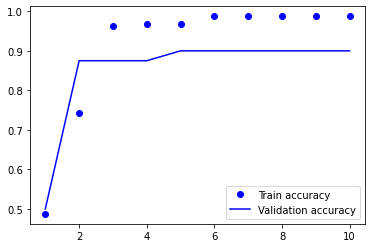

In [0]:
eval_metric(emb_history, 'accuracy')

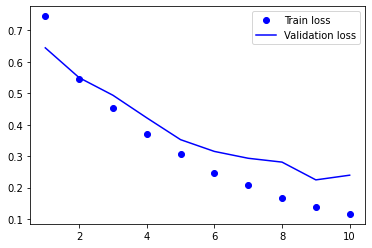

In [0]:
eval_metric(emb_history, 'loss')

Test embeddings on the testing data

In [0]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

In [0]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

50/50 [==============================] - 0s 100us/step
/n
Test accuracy of word embeddings model: 92.00%


Extract a matrix of size tweets x embeddings

In [0]:
embeddings = emb_model.layers[0].get_weights()[0]